In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint
from sklearn.linear_model import Ridge
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 250]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 250)   y shape:  (4383, 1)
train1 X: (3618, 250)  train1 y: (3618, 1)  Test1 X shape: (365, 250)  Test1 y shape: (365, 1)
validation1 X: (400, 250)  validation1 y: (400, 1)
train2 X: (3293, 250)  train2 y: (3293, 1)  Test2 X: (365, 250)  Test2 y: (365, 1)
validation2 X: (360, 250)  validation2 y: (360, 1)


In [4]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [5]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,250):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [6]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [7]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  149


In [8]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def ridge(a,train_X,train_y,test_X,test_y):
    # scaling and modeling
    scalerX = StandardScaler()
    scalerX.fit(train_X)
    train_X = scalerX.transform(train_X)
    test_X = scalerX.transform(test_X)
    
    scalery = StandardScaler() 
    scalery.fit(train_y) 
    train_y = scalery.transform(train_y) 
    
    
    alpha=a
    ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
  
    ri.fit(train_X,train_y)

    y_pred1 = ri.predict(test_X)
    y_pred1 = scalery.inverse_transform(y_pred1)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    


# scaling and modeling
scaler = MinMaxScaler()
train1_X0_scaled = scaler.fit_transform(train1_X0)
test1_X0_scaled = scaler.transform(test1_x0)

train1_X1_scaled = scaler.fit_transform(train1_X1)
test1_X1_scaled = scaler.transform(test1_x1)

train1_X2_scaled = scaler.fit_transform(train1_X2)
test1_X2_scaled = scaler.transform(test1_x2)

train1_X3_scaled = scaler.fit_transform(train1_X3)
test1_X3_scaled = scaler.transform(test1_x3)


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [9]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 149) (400, 149)


((4018, 149), (4018, 1))

In [10]:

para = np.arange(0.01, 3000000, 10000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')
        

alpha: 0.01
Best RMSE is updated! 
The mean absolute error is:  22.367317217875666
The root mean squared error is:  45.36429770451398
The correlation is:  0.742940521344389
----------------------------------------
alpha: 10000.01
Best RMSE is updated! 
The mean absolute error is:  16.994407617687816
The root mean squared error is:  32.45584726153253
The correlation is:  0.7960044059197683
----------------------------------------
alpha: 20000.01
Best RMSE is updated! 
The mean absolute error is:  14.758834969128678
The root mean squared error is:  28.01753214247817
The correlation is:  0.7889304904260666
----------------------------------------
alpha: 30000.01
Best RMSE is updated! 
The mean absolute error is:  13.32794033888594
The root mean squared error is:  25.17602024869022
The correlation is:  0.7843726646837189
----------------------------------------
alpha: 40000.01
Best RMSE is updated! 
The mean absolute error is:  12.242420650606757
The root mean squared error is:  23.1083581

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [10]:
para =[160000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train3_X,train3_y,test1_X1,test1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 160000
Best RMSE is updated! 
The mean absolute error is:  4.668937734842471
The root mean squared error is:  5.0322511690938025
The correlation is:  0.7337720064293725
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.8622505738584394
The root mean squared error is:  3.4919482429540083
The correlation is:  0.9130835230524874
----------------------------------------


In [12]:
alpha=200000 
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

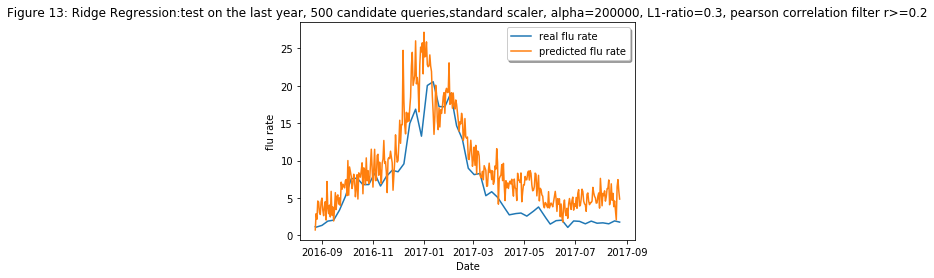

In [13]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 13: Ridge Regression:test on the last year, 500 candidate queries,standard scaler, alpha=200000, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

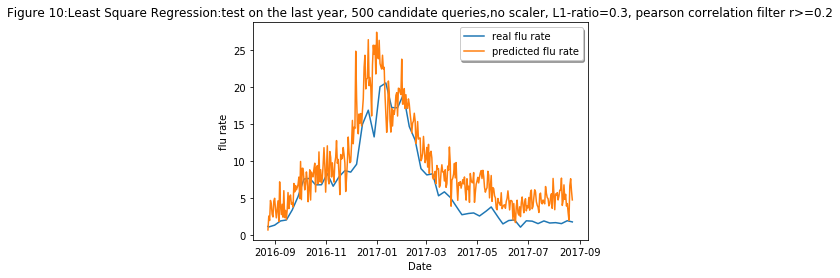

In [14]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 10:Least Square Regression:test on the last year, 500 candidate queries,no scaler, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [11]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [12]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [13]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  163


# scaling and modeling
scaler = MinMaxScaler()
train2_X0_scaled = scaler.fit_transform(train2_X0)
test2_X0_scaled = scaler.transform(test2_X0)

train2_X1_scaled = scaler.fit_transform(train2_X1)
test2_X1_scaled = scaler.transform(test2_X1)

train2_X2_scaled = scaler.fit_transform(train2_X2)
test2_X2_scaled = scaler.transform(test2_X2)

train2_X3_scaled = scaler.fit_transform(train2_X3)
test2_X3_scaled = scaler.transform(test2_X3)


para = range(1,100)
para = np.arange(0.01, 10.0, 0.01)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

In [14]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 163) (360, 163)


((3653, 163), (3653, 1))

In [18]:

para =np.arange(1, 50000, 10)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train2_X1,train2_y,val2_X1,val2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 1
Best RMSE is updated! 
The mean absolute error is:  4.253468429018292
The root mean squared error is:  7.8531237084123084
The correlation is:  0.4974028900568927
----------------------------------------
alpha: 11
alpha: 21
alpha: 31
alpha: 41
alpha: 51
alpha: 61
alpha: 71
alpha: 81
alpha: 91
alpha: 101
alpha: 111
alpha: 121
alpha: 131
alpha: 141
alpha: 151
alpha: 161
alpha: 171
alpha: 181
alpha: 191
alpha: 201
alpha: 211
alpha: 221
alpha: 231
alpha: 241
alpha: 251
alpha: 261
alpha: 271
alpha: 281
alpha: 291
alpha: 301
alpha: 311
alpha: 321
alpha: 331
alpha: 341
alpha: 351
alpha: 361
alpha: 371
alpha: 381
alpha: 391
alpha: 401
alpha: 411
alpha: 421
alpha: 431
alpha: 441
alpha: 451
alpha: 461
alpha: 471
alpha: 481
alpha: 491
alpha: 501
alpha: 511
alpha: 521
alpha: 531
alpha: 541
alpha: 551
alpha: 561
alpha: 571
alpha: 581
alpha: 591
alpha: 601
alpha: 611
alpha: 621
alpha: 631
alpha: 641
alpha: 651
alpha: 661
alpha: 671
alpha: 681
alpha: 691
alpha: 701
alpha: 711
alpha: 721
alpha

alpha: 6841
alpha: 6851
alpha: 6861
alpha: 6871
alpha: 6881
alpha: 6891
alpha: 6901
alpha: 6911
alpha: 6921
alpha: 6931
alpha: 6941
alpha: 6951
alpha: 6961
alpha: 6971
alpha: 6981
alpha: 6991
alpha: 7001
alpha: 7011
alpha: 7021
alpha: 7031
alpha: 7041
alpha: 7051
alpha: 7061
alpha: 7071
alpha: 7081
alpha: 7091
alpha: 7101
alpha: 7111
alpha: 7121
alpha: 7131
alpha: 7141
alpha: 7151
alpha: 7161
alpha: 7171
alpha: 7181
alpha: 7191
alpha: 7201
alpha: 7211
alpha: 7221
alpha: 7231
alpha: 7241
alpha: 7251
alpha: 7261
alpha: 7271
alpha: 7281
alpha: 7291
alpha: 7301
alpha: 7311
alpha: 7321
alpha: 7331
alpha: 7341
alpha: 7351
alpha: 7361
alpha: 7371
alpha: 7381
alpha: 7391
alpha: 7401
alpha: 7411
alpha: 7421
alpha: 7431
alpha: 7441
alpha: 7451
alpha: 7461
alpha: 7471
alpha: 7481
alpha: 7491
alpha: 7501
alpha: 7511
alpha: 7521
alpha: 7531
alpha: 7541
alpha: 7551
alpha: 7561
alpha: 7571
alpha: 7581
alpha: 7591
alpha: 7601
alpha: 7611
alpha: 7621
alpha: 7631
alpha: 7641
alpha: 7651
alpha: 7661
alph

alpha: 13501
alpha: 13511
alpha: 13521
alpha: 13531
alpha: 13541
alpha: 13551
alpha: 13561
alpha: 13571
alpha: 13581
alpha: 13591
alpha: 13601
alpha: 13611
alpha: 13621
alpha: 13631
alpha: 13641
alpha: 13651
alpha: 13661
alpha: 13671
alpha: 13681
alpha: 13691
alpha: 13701
alpha: 13711
alpha: 13721
alpha: 13731
alpha: 13741
alpha: 13751
alpha: 13761
alpha: 13771
alpha: 13781
alpha: 13791
alpha: 13801
alpha: 13811
alpha: 13821
alpha: 13831
alpha: 13841
alpha: 13851
alpha: 13861
alpha: 13871
alpha: 13881
alpha: 13891
alpha: 13901
alpha: 13911
alpha: 13921
alpha: 13931
alpha: 13941
alpha: 13951
alpha: 13961
alpha: 13971
alpha: 13981
alpha: 13991
alpha: 14001
alpha: 14011
alpha: 14021
alpha: 14031
alpha: 14041
alpha: 14051
alpha: 14061
alpha: 14071
alpha: 14081
alpha: 14091
alpha: 14101
alpha: 14111
alpha: 14121
alpha: 14131
alpha: 14141
alpha: 14151
alpha: 14161
alpha: 14171
alpha: 14181
alpha: 14191
alpha: 14201
alpha: 14211
alpha: 14221
alpha: 14231
alpha: 14241
alpha: 14251
alpha: 14261

alpha: 19961
alpha: 19971
alpha: 19981
alpha: 19991
alpha: 20001
alpha: 20011
alpha: 20021
alpha: 20031
alpha: 20041
alpha: 20051
alpha: 20061
alpha: 20071
alpha: 20081
alpha: 20091
alpha: 20101
alpha: 20111
alpha: 20121
alpha: 20131
alpha: 20141
alpha: 20151
alpha: 20161
alpha: 20171
alpha: 20181
alpha: 20191
alpha: 20201
alpha: 20211
alpha: 20221
alpha: 20231
alpha: 20241
alpha: 20251
alpha: 20261
alpha: 20271
alpha: 20281
alpha: 20291
alpha: 20301
alpha: 20311
alpha: 20321
alpha: 20331
alpha: 20341
alpha: 20351
alpha: 20361
alpha: 20371
alpha: 20381
alpha: 20391
alpha: 20401
alpha: 20411
alpha: 20421
alpha: 20431
alpha: 20441
alpha: 20451
alpha: 20461
alpha: 20471
alpha: 20481
alpha: 20491
alpha: 20501
alpha: 20511
alpha: 20521
alpha: 20531
alpha: 20541
alpha: 20551
alpha: 20561
alpha: 20571
alpha: 20581
alpha: 20591
alpha: 20601
alpha: 20611
alpha: 20621
alpha: 20631
alpha: 20641
alpha: 20651
alpha: 20661
alpha: 20671
alpha: 20681
alpha: 20691
alpha: 20701
alpha: 20711
alpha: 20721

alpha: 26421
alpha: 26431
alpha: 26441
alpha: 26451
alpha: 26461
alpha: 26471
alpha: 26481
alpha: 26491
alpha: 26501
alpha: 26511
alpha: 26521
alpha: 26531
alpha: 26541
alpha: 26551
alpha: 26561
alpha: 26571
alpha: 26581
alpha: 26591
alpha: 26601
alpha: 26611
alpha: 26621
alpha: 26631
alpha: 26641
alpha: 26651
alpha: 26661
alpha: 26671
alpha: 26681
alpha: 26691
alpha: 26701
alpha: 26711
alpha: 26721
alpha: 26731
alpha: 26741
alpha: 26751
alpha: 26761
alpha: 26771
alpha: 26781
alpha: 26791
alpha: 26801
alpha: 26811
alpha: 26821
alpha: 26831
alpha: 26841
alpha: 26851
alpha: 26861
alpha: 26871
alpha: 26881
alpha: 26891
alpha: 26901
alpha: 26911
alpha: 26921
alpha: 26931
alpha: 26941
alpha: 26951
alpha: 26961
alpha: 26971
alpha: 26981
alpha: 26991
alpha: 27001
alpha: 27011
alpha: 27021
alpha: 27031
alpha: 27041
alpha: 27051
alpha: 27061
alpha: 27071
alpha: 27081
alpha: 27091
alpha: 27101
alpha: 27111
alpha: 27121
alpha: 27131
alpha: 27141
alpha: 27151
alpha: 27161
alpha: 27171
alpha: 27181

alpha: 32881
alpha: 32891
alpha: 32901
alpha: 32911
alpha: 32921
alpha: 32931
alpha: 32941
alpha: 32951
alpha: 32961
alpha: 32971
alpha: 32981
alpha: 32991
alpha: 33001
alpha: 33011
alpha: 33021
alpha: 33031
alpha: 33041
alpha: 33051
alpha: 33061
alpha: 33071
alpha: 33081
alpha: 33091
alpha: 33101
alpha: 33111
alpha: 33121
alpha: 33131
alpha: 33141
alpha: 33151
alpha: 33161
alpha: 33171
alpha: 33181
alpha: 33191
alpha: 33201
alpha: 33211
alpha: 33221
alpha: 33231
alpha: 33241
alpha: 33251
alpha: 33261
alpha: 33271
alpha: 33281
alpha: 33291
alpha: 33301
alpha: 33311
alpha: 33321
alpha: 33331
alpha: 33341
alpha: 33351
alpha: 33361
alpha: 33371
alpha: 33381
alpha: 33391
alpha: 33401
alpha: 33411
alpha: 33421
alpha: 33431
alpha: 33441
alpha: 33451
alpha: 33461
alpha: 33471
alpha: 33481
alpha: 33491
alpha: 33501
alpha: 33511
alpha: 33521
alpha: 33531
alpha: 33541
alpha: 33551
alpha: 33561
alpha: 33571
alpha: 33581
alpha: 33591
alpha: 33601
alpha: 33611
alpha: 33621
alpha: 33631
alpha: 33641

alpha: 39341
alpha: 39351
alpha: 39361
alpha: 39371
alpha: 39381
alpha: 39391
alpha: 39401
alpha: 39411
alpha: 39421
alpha: 39431
alpha: 39441
alpha: 39451
alpha: 39461
alpha: 39471
alpha: 39481
alpha: 39491
alpha: 39501
alpha: 39511
alpha: 39521
alpha: 39531
alpha: 39541
alpha: 39551
alpha: 39561
alpha: 39571
alpha: 39581
alpha: 39591
alpha: 39601
alpha: 39611
alpha: 39621
alpha: 39631
alpha: 39641
alpha: 39651
alpha: 39661
alpha: 39671
alpha: 39681
alpha: 39691
alpha: 39701
alpha: 39711
alpha: 39721
alpha: 39731
alpha: 39741
alpha: 39751
alpha: 39761
alpha: 39771
alpha: 39781
alpha: 39791
alpha: 39801
alpha: 39811
alpha: 39821
alpha: 39831
alpha: 39841
alpha: 39851
alpha: 39861
alpha: 39871
alpha: 39881
alpha: 39891
alpha: 39901
alpha: 39911
alpha: 39921
alpha: 39931
alpha: 39941
alpha: 39951
alpha: 39961
alpha: 39971
alpha: 39981
alpha: 39991
alpha: 40001
alpha: 40011
alpha: 40021
alpha: 40031
alpha: 40041
alpha: 40051
alpha: 40061
alpha: 40071
alpha: 40081
alpha: 40091
alpha: 40101

alpha: 45801
alpha: 45811
alpha: 45821
alpha: 45831
alpha: 45841
alpha: 45851
alpha: 45861
alpha: 45871
alpha: 45881
alpha: 45891
alpha: 45901
alpha: 45911
alpha: 45921
alpha: 45931
alpha: 45941
alpha: 45951
alpha: 45961
alpha: 45971
alpha: 45981
alpha: 45991
alpha: 46001
alpha: 46011
alpha: 46021
alpha: 46031
alpha: 46041
alpha: 46051
alpha: 46061
alpha: 46071
alpha: 46081
alpha: 46091
alpha: 46101
alpha: 46111
alpha: 46121
alpha: 46131
alpha: 46141
alpha: 46151
alpha: 46161
alpha: 46171
alpha: 46181
alpha: 46191
alpha: 46201
alpha: 46211
alpha: 46221
alpha: 46231
alpha: 46241
alpha: 46251
alpha: 46261
alpha: 46271
alpha: 46281
alpha: 46291
alpha: 46301
alpha: 46311
alpha: 46321
alpha: 46331
alpha: 46341
alpha: 46351
alpha: 46361
alpha: 46371
alpha: 46381
alpha: 46391
alpha: 46401
alpha: 46411
alpha: 46421
alpha: 46431
alpha: 46441
alpha: 46451
alpha: 46461
alpha: 46471
alpha: 46481
alpha: 46491
alpha: 46501
alpha: 46511
alpha: 46521
alpha: 46531
alpha: 46541
alpha: 46551
alpha: 46561

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [15]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [1,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train4_X,train4_y,test2_X1,test2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 1
Best RMSE is updated! 
The mean absolute error is:  2.4420124989335625
The root mean squared error is:  3.165511441435139
The correlation is:  0.9044165522306603
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.4384173692675826
The root mean squared error is:  3.161758652011802
The correlation is:  0.9045851596642503
----------------------------------------


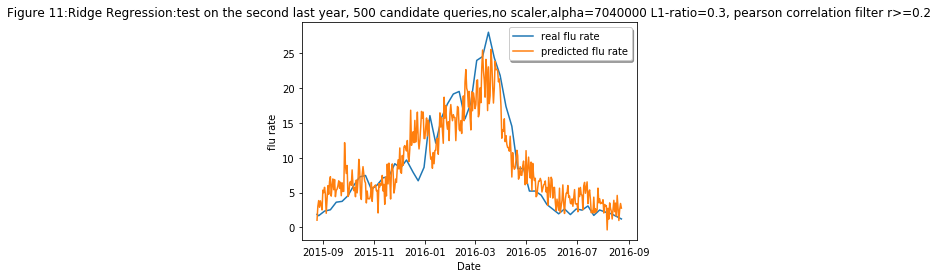

In [36]:
alpha=1
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 11:Ridge Regression:test on the second last year, 500 candidate queries,no scaler,alpha=7040000 L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

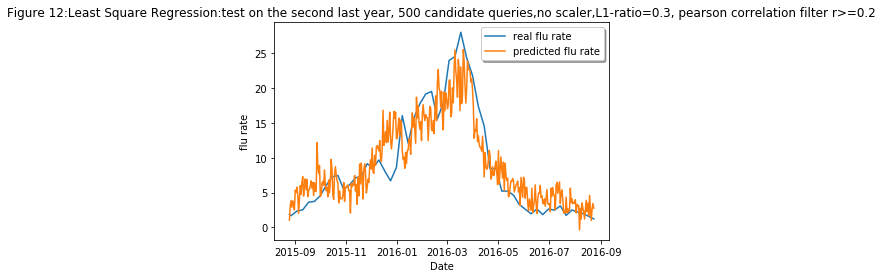

In [37]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 12:Least Square Regression:test on the second last year, 500 candidate queries,no scaler,L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()